# SpotRM API (Python)

# API Manual, including examples 
 
BSD 3-Clause License<br>
Copyright (c) 2020/2021 Awametox AB<br>
You should have received a copy of the BSD 3-Clause License
along with this script; <br>
if not, see <https://github.com/Awamegit/SpotRM_API_examples/blob/master/LICENSE>

### 1. Introduction & Essential set-up
SpotRM on the Web comes with an API that is included in the subsription. It allows for individual mining of your data vs the SpotRM database. E.g. different views, integration into your cheminformatics system, high-throuput analysis, etc, etc. <br>
Here we show the principle use of the API with some basic and some more advanced examples, based on Python in this Jupyter Notebook.

#### 1.1 First of, some minimum, essential library imports:
(note that *requests* and other libraries might not be installed and requires setup, check the Readme.MD for details)

In [1]:
import requests
import json
from requests.auth import HTTPBasicAuth

*Additional (optional)libraries:*

In [2]:
import os
# add more libraries here.
# Other optional libraries used in this tutorial are found with the examples themselves.

#### 1.2 recurring variables for get and post
Furthermore authentication access. There are two options here: either clear text (not recommendable). Use:<br>
`authData = HTTPBasicAuth('my_email@somewhere.com', 'my_super_secure_PassW0rd!` <br>
Here we make use of the username and password stored in our OS environment. In this case called *STDEMAIL* and *SPOTRM_PWD*.<br>
Every API call later made will contain authentication info.

In [3]:
BASEURL = "https://www.spotrm.com/api/v1"
headers = {"content-type": "application/json"}
authData = HTTPBasicAuth(os.environ["STDEMAIL"], os.environ["SPOTRM_PWD"])

You can also create a token for authenticating:

In [4]:
url = BASEURL + "/tokens/"
response = requests.post(url, auth=authData)
token = json.loads(response.text)["token"]

Instead of using *authData* as `auth`, you can now use the token *token* instead as an additional layer of security.
<br>
See the notebook/script example "useToken".

### 2. Get help on API via API
This section describes a simple and minimalistic API call requesting */help*. This will list all possible API calls. Username and Password are used for the authentication. <br>
The returned data is always formatted as JSON. In Python this can be dealt with as a dictionary. Note that parts of the entrie in such a dictionary may contain a list, particularly *References* which in turn may contain a dictionary. <br>
You can use the standard http(s) error code list to check for status errors. Code 200 stands for no error (i.e. ok).

In [5]:
response = requests.get(BASEURL + "/help", auth=authData)
respDict = json.loads(response.text)
if response.status_code == 200:
    for key in respDict:
        print(key + ": " + respDict[key])    
else:
    print("There was an error: " + json.loads(response.text)["message"])

/api/v1/get/drug/id/<id>: Find all data on a drug with the supplied ID
/api/v1/get/drug/smarts_id/<smarts_id>: Get drug records linked to given smarts_id
/api/v1/get/image/inchi: Generate highlighted image of InChI where it matches <smarts_id>
/api/v1/get/image/molfile: Generate highlighted image of molfile where it matches <smarts_id>
/api/v1/get/image/smiles: Generate highlighted image of <smiles> where it matches <smarts_id>
/api/v1/help: Print available functions and their documentation.
/api/v1/search/drug/substructure/inchi: Find all drugs containing your query structure posted as InChI as a substructure
/api/v1/search/drug/substructure/molfile: Find all drugs containing your query structure posted as Molfile as a substructure
/api/v1/search/drug/substructure/smiles: Find all drugs containing your query posted as smiles as a substructure
/api/v1/search/drug/text/<text>: Find all drugs with <text> in their records
/api/v1/search/smarts/inchi: Find all SMARTS which match the posted

### 3. Examples of API calls
Following here are some examples of API calls. Very simplistic, including means of output/working with the JSON format. The latter really depends on your use case.
#### 3.1  Here an example of checking for a drug ID (ID = SpotRM database specific):
This is a simple example where you would use the SPOT RM database ID of a drug (known/retrieved by other means, see further below). <br>Note: no error checking is done in this example when looking at ID #3.<br>
Also note how *References* is a list of dictionaries within the dictionary output.

In [6]:
lookup_an_ID = requests.get(BASEURL + "/get/drug/id/3", auth=authData)
respDict = json.loads(lookup_an_ID.text)

print("\n---- JSON output raw / unformatted -----")
print(respDict)
    
print("\n---- JSON output formatted 1 -----")
print(json.dumps(respDict, indent = 2))
    
print("\n---- JSON output formatted 2 -----")
for key, value in respDict.items():
    print(key, " = ", value)  


---- JSON output raw / unformatted -----
{'ChemName': '1,5-dimethyl-2-phenyl-pyrazol-3-one', 'ColourCode': 'Orange', 'DrugName': 'phenazone', 'MarketStatus': 'On the market (2020)', 'References': [{'Ref': 'aminophenazone.pdf', 'RefType': 'Mgph'}], 'Synonym': 'antipyrine'}

---- JSON output formatted 1 -----
{
  "ChemName": "1,5-dimethyl-2-phenyl-pyrazol-3-one",
  "ColourCode": "Orange",
  "DrugName": "phenazone",
  "MarketStatus": "On the market (2020)",
  "References": [
    {
      "Ref": "aminophenazone.pdf",
      "RefType": "Mgph"
    }
  ],
  "Synonym": "antipyrine"
}

---- JSON output formatted 2 -----
ChemName  =  1,5-dimethyl-2-phenyl-pyrazol-3-one
ColourCode  =  Orange
DrugName  =  phenazone
MarketStatus  =  On the market (2020)
References  =  [{'Ref': 'aminophenazone.pdf', 'RefType': 'Mgph'}]
Synonym  =  antipyrine


And here, only a single value (of above example).<br>
The available API color results are:<br>
Red, Orange, Green<br>
*termcolor* doesn't have "Orange", hence the if/else clause.

In [7]:
!pip install termcolor
from termcolor import colored
outCol = respDict['ColourCode']
if outCol == 'Orange':
    outCol = 'yellow'
else:
    outCol = outCol.lower()

print("\n---- single value output, e.g. formatted in color -----")
print(colored(text=respDict['DrugName'],color=outCol))


---- single value output, e.g. formatted in color -----
phenazone


#### 3.2 substructure searching
Here an example on using substructre searching of a smiles string. This uses a POST call. <br>
Note that the structure a smiles at this point is of type String and doesn't require a chemistry library such as RDKit.<br>
(simple print output; no error checking)

In [8]:
url = "https://www.spotrm.com/api/v1/search/drug/substructure/smiles"
#smiles = "C1CN(CCN1CC2=CC3=C(C=C2)OCO3)C(=O)COC4=CC=C(C=C4)Cl"
smiles = "CC(=O)NC1=CC=C(O)C=C1"
response = requests.post(url=url, data=json.dumps(smiles), headers=headers, auth=authData)
respDict = json.loads(response.text)
print(json.dumps(respDict, indent = 2))     

{
  "40": {
    "ChemName": "N-(4-{[2-hydroxy-3-(propan-2-ylamino)propyl]oxy}phenyl)acetamide",
    "ColourCode": "Red",
    "DrugName": "practolol",
    "MarketStatus": "Withdrawn",
    "References": [
      {
        "Ref": "practolol.pdf",
        "RefType": "Mgph"
      }
    ],
    "Synonym": ""
  },
  "76": {
    "ChemName": "N-(4-hydroxyphenyl)acetamide",
    "ColourCode": "Red",
    "DrugName": "paracetamol",
    "MarketStatus": "On the market (2020)",
    "References": [
      {
        "Ref": "paracetamol.pdf",
        "RefType": "Mgph"
      },
      {
        "Ref": "MiC_BQI.pdf",
        "RefType": "MiC"
      }
    ],
    "Synonym": "acetaminophen"
  },
  "96": {
    "ChemName": "4-butyl-1-(4-hydroxyphenyl)-2-phenylpyrazolidine-3,5-dione",
    "ColourCode": "Red",
    "DrugName": "oxyphenbutazone",
    "MarketStatus": "Withdrawn 1985-1986",
    "References": [
      {
        "Ref": "oxyphenbutazone.pdf",
        "RefType": "Mgph"
      }
    ],
    "Synonym": ""
  },
  "

#### 3.3 Obtain only the external reference for above input compound:
The resulting *References* may contain multiple answers, often refering to the PDFs embedded in SPOTRM (currently only viewable only from SPOTRM Web GUI) and are denoted as *Reftype: Mgph* or *MiC*. External linkes are denoted as *Link*. Below example iterates through the resulting JSON and prints only the hyperlink. In Jupyter you can open this linke directly by clicking on it. 

In [9]:
def getRef(refResponse):
    for key, value in refResponse.items():
        for key2, subvalue1 in value.items():
            if (key2 == 'References'):
                for subvalue2 in subvalue1:
                    for refitem, refvalue in subvalue2.items():
                        if(refvalue == 'Link'):
                            print(subvalue1[0]['Ref'])

Since we are using a function, this has to be called first. For more examples on function useage and other API examples, see chapter #4.

In [10]:
getRef(refResponse = respDict)

https://www.ncbi.nlm.nih.gov/books/NBK548853/


### 4. More API examples (using functions)
Below we show some examples of API calls defined via functions; practical for more complex scripts with repeating the same type of calls.<br>
**All following examples use token based authentication**
#### 4.1 
(note that token has already been defined herein, see output line 4; it is repeated for tutorial sake)

In [11]:
def get_api_token() -> tuple[str, str] | None:
    """ Function to retrieve api authentication token
    :return: The token to use for authentication; second element required, but not used.
    """
    url = f"{BASEURL}/tokens/"
    response = requests.post(url, auth=authData)
    if response.status_code == 200:
        return response.json().get("token", ""), ""
    else:
        error_message = response.json().get("message", "Unknown error")
        print(f"There was an error: {error_message}")
        return None

In [12]:
def get_alerts(smiles: list, token: str) -> dict | None:
    """ Use token to query database to find alerts for a smiles string

    :param smiles: The SMILES string for which to find alerts
    :param token: The token to use for authentication
    :return: alert ID and the alert description
    """

    url = f"{BASEURL}/search/smarts/smiles"
    response = requests.post(url, data=json.dumps(smiles), headers=headers, auth=token)
    if response.status_code == 200:
        return response.json()
    else:
        error_message = response.json().get("message", "Unknown error")
        print(f"There was an error: {error_message}")
        return None


def get_drug(alertID: list, token: tuple) -> dict | None:
    """ Use the obained token to find drugs associated with an alert ID:
    :param alertID: The alert ID for which to find drugs
    :param token: The token to use for authentication
    :return: A dictionary with the drugs associated with the alert ID
    """
    url = f"{BASEURL}/get/drug/smarts_id/{alertID}"
    response = requests.get(url, auth=token)
    if response.status_code == 200:
        return response.json()
    else:
        error_message = response.json().get("message", "Unknown error")
        print(f"There was an error in get_drug function: {error_message}")
        return None

Here we specifically find the SpotRM database ID of a potential alert (here for the smiles **c1ccccc1N(C)C**) then retrieves all drugs associated with that particular alert.

In [13]:
token = get_api_token()
if token:
    alerts = get_alerts("c1ccccc1N(C)C", token)

    print("\nThe following alert was found for your structure:")
    for item in alerts:
        print("Alert ID: " + item[0] + ' is "' + item[1] + '"')
    drugs = get_drug(alerts[0][0], token)
    print("\nThe following drugs are associated with this alert:")
    for key in drugs:
        print(drugs[key]["DrugName"])
else:
    print("Failed to retrieve token.")


The following alert was found for your structure:
Alert ID: 3 is "4-H-Benzene-N-C (not acyl)"

The following drugs are associated with this alert:
nefazodone
trazodone
diclofenac
clozapine
olanzapine
quetiapine
fluperlapine
mianserin
imipramine
erlotinib
phenylbutazone
chlorpromazine
panadiplon
1-Arylpyrazoles
loxapine
mefenamic acid
idelalisib
meclofenamic acid


#### 4.2 Structures and structural alerts
First import some additional libraries. *IPython* packages should be automatically installed since you are using Jupyter.

In [15]:
import datetime # used in filename determination
from IPython.display import SVG # useful in graphical environment such as Jupyter

Below function retrieves an image highlighting the region in a query structure provided as a smiles string which triggers a particular reactive metabolite alert specified by its smarts id.<br>

The relevant smarts_id would be identified by an earlier search using<br>
`/api/v1/search/smarts/smiles` 
(see e.g. 3.1)<br>

In [16]:
def getImage(smiles, smarts_id):
    url = BASEURL + "/get/image/smiles"
    query = {"smiles": smiles, "smarts_id": smarts_id}
    fileOutput = "smilesImage_" + str(datetime.datetime.now().date()) + ".svg"

    response = requests.post(
        url, data=json.dumps(query), headers=headers, auth=authData
    )
    if response.status_code == 200:
        with open(fileOutput, "wb") as f:
            f.write(response.content)
        display(SVG(response.content)) #alternatively: display(SVG(filename=fileOutput))
    else:
        print("There was an error: " + json.loads(response.text)["message"])

After calling this function, it will output an SVG image file *smilesImage_<date>.svg*<br>
SVG is currently the only imagme output format available.<br>
In Jupyter you will also see the image output directly.

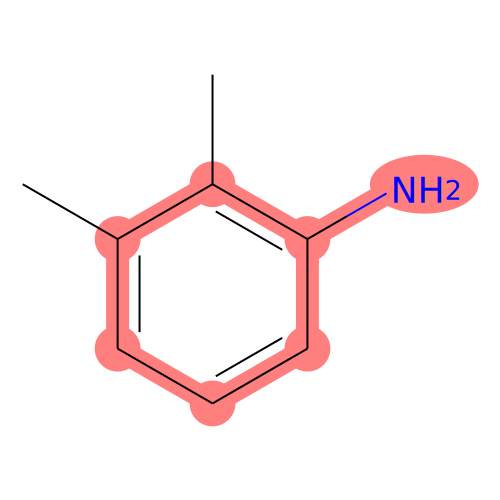

In [17]:
getImage("c1ccc(C)c(C)c1N", 1)